## Importar ferramentas necessárias:

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#### Feito o upload da pasta de imagens no colab, descompactar no diretório.

In [ ]:
#unzip pasta de imagens
!unzip /content/Tomato.zip

### Carregar e preparar o dataset

In [ ]:
#dataset criado com a pasta, separado para treino e validação(usando 30%)
#classes representadas em one-hot encoding, definidas na ordem que aparecem na pasta
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Tomato',
    labels="inferred",
    label_mode="categorical",
    image_size=(299, 299),
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed = 9)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Tomato',
    labels="inferred",
    label_mode="categorical",
    image_size=(299,299),
    validation_split=0.3,
    subset="validation",
    shuffle = True,
    seed = 9)

Found 4263 files belonging to 8 classes.
Using 2985 files for training.
Found 4263 files belonging to 8 classes.
Using 1278 files for validation.


## Considerações iniciais sobre o modelo:
### 1. Camada de MaxPooling inserida após o esqueleto para reduzir o número de parâmetros. Pool_size e strides foram definidos com base na observação do desempenho do modelo e no tempo de treinamento.
### 2. O mesmo vale para a inserção da camada Densa (e o número de neurônios) entre a de pooling e a de saída.
### 3. Em consonância à representação (one-hot encoding) das classes das imagens e sua natureza qualitativa, a função de perda foi escolhida.
### 4. Otimizador Adam: Uma versão do algoritmo de gradiente descendene estocástico, Adam vem de ADAptive Moment estimation, usa gradientes passados para calcular os atuais.
### 4. Treinar algumas das últimas camadas da resnet transferida ajuda a convergir mais rápido e atingir resultados um pouco melhores, pois elas são responsáveis por filtrar os padrões menos abstratos.

In [ ]:
backbone = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299,3))

#garantir que algumas camadas da resnet possam ser treinadas, exceto todas as outras
for i in range (len(backbone.layers)-7):
    backbone.layers[i].trainable = False
    
resnet_model = Sequential([backbone, MaxPooling2D(
    pool_size=(4,4), strides=3, padding="valid"), Flatten(),
                           Dense(120, activation = 'relu'),
                           Dense(8, activation = 'softmax')])

resnet_model.summary()

resnet_model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'categorical_crossentropy',  metrics = ['Accuracy'])
history = resnet_model.fit(
    x=train_ds,
    validation_data = val_ds,
    batch_size=32,
    epochs=20,
    shuffle=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 2048)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_10 (Dense)            (None, 120)               2211960   
                                                                 
 dense_11 (Dense)            (None, 8)                 968       
                                                                 
Total params: 25,800,640
Trainable params: 5,628,480
Non-trainable params: 20,172,160
__________________________________

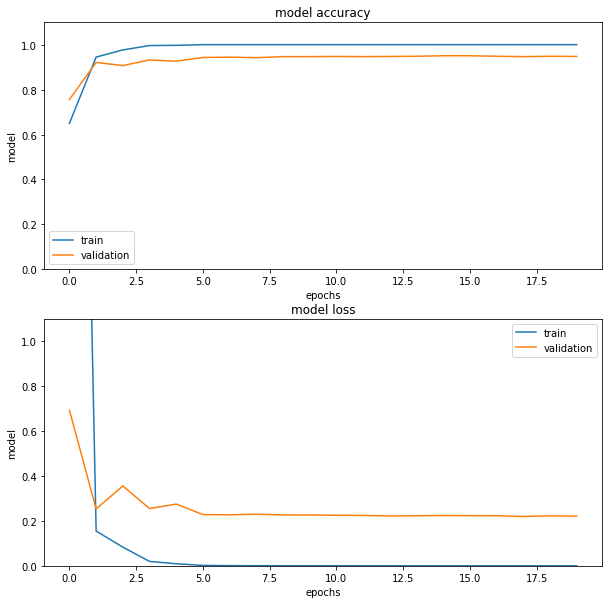

In [ ]:
fig, axs = plt.subplots(2,figsize=(10,10))

axs[0].plot(history.history['Accuracy'])
axs[0].plot(history.history['val_Accuracy'])
axs[0].set_title('model accuracy')
axs[0].legend(['train', 'validation'])


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].legend(['train', 'validation'])
for ax in axs.flat:
    ax.set_ylim([0, 1.1])
    ax.set(xlabel='epochs', ylabel='model')

#### Após 20 epochs, aparentemente a função de perda convergiu para um valor de mínimo local e o modelo performou bem, apesar de ter "decorado" o dataset de treino

### A imagem abaixo mostra como é a definição dos resultados em uma matriz de confusão com mais de duas classes.
![alt text](Result%20types.png "Title")

,BA,HA,MP,SE,SL,TP,TU,ZC
precision,0.983871,0.937799,0.961806,0.849057,0.947368,0.948718,0.976879,1.000000
recall,0.945736,0.946860,0.982270,0.882353,0.920930,0.902439,0.982558,0.974684
f1-score,0.964427,0.942308,0.971930,0.865385,0.933962,0.925000,0.979710,0.987179
class-accuracy,0.992958,0.981221,0.987480,0.967136,0.978091,0.995305,0.994523,0.998435


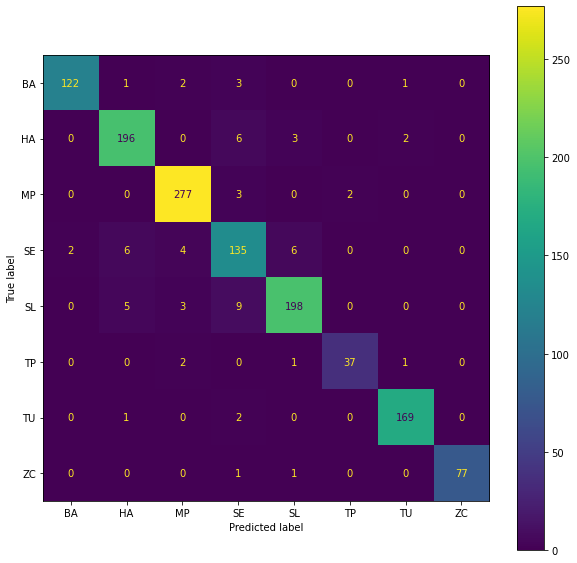

In [ ]:
pred = [] #para armazenar as predições
true = [] #resultados reais
new_labels = ['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']

for image_batch, label_batch in val_ds: #iterar sobre cada lote do dataset, que contém as imagens e suas classes.
    true.append(label_batch)
    preds = resnet_model.predict(image_batch)
    pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in true], axis = 0)
predicted_labels = tf.concat([item for item in pred], axis = 0)

a = np.array(correct_labels)
y_true = np.where(a==1)[1]#decodificar respostas
y_pred = np.array(predicted_labels)

cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=new_labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

#Calcular resultados falsos positivos, falsos negativos, verdadeiros negativos e verdadeiros positivos
#adaptados aos problemas de multiclasses
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
ACC = (TP+TN)/(TP+FP+FN+TN)

#dataframe com métricas relevantes
metrics = pd.DataFrame.from_dict(classification_report(y_true, y_pred, output_dict = True))
metrics.drop(labels = ['accuracy', 'macro avg','weighted avg'], axis = 1, inplace = True)
metrics.drop(labels = ['support'], axis = 0, inplace = True)
metrics.loc[len(metrics)] = ACC
metrics.rename(index={3:'class-accuracy'}, inplace = True)
metrics.columns = new_labels
metrics

### Considerações finais:

#### Verifica-se menor recall e f1-score na categoria SE
#### O modelo foi criado para fins de aprendizado